## TME 10 : Variationnal Auto-Encoder

In [1]:
import numpy as np
try:
    import torch
except:
    !pip3 install torch==1.2.0+cu92 torchvision==0.4.0+cu92 -f https://download.pytorch.org/whl/torch_stable.html
    import torch
    
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data
from torch.utils.tensorboard import SummaryWriter

import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.utils as vutils
from torchvision.utils import make_grid

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from datetime import datetime


In [2]:
b_size = 100

transform = transforms.Compose([transforms.ToTensor()])

mnist_train = datasets.MNIST(root="", train=True, download=True, transform=transform)
print(mnist_train)
mnist_train_loader = torch.utils.data.DataLoader(dataset=mnist_train,
                                               batch_size=b_size,
                                               shuffle=True,
                                               drop_last = True)
print(mnist_train_loader)

mnist_test = datasets.MNIST(root="", train = False, download=True, transform=transform)
print(mnist_test)
mnist_test_loader = torch.utils.data.DataLoader(dataset=mnist_test,
                                               batch_size=b_size,
                                               shuffle=False,
                                               drop_last = True)
print(mnist_test_loader)

nBatchTrain = len(mnist_train_loader)
nBatchTest = len(mnist_test_loader)

9913344it [00:03, 3026347.94it/s]                                               


Extracting MNIST/raw/train-images-idx3-ubyte.gz to MNIST/raw



29696it [00:00, 3202726.96it/s]                                                 


Extracting MNIST/raw/train-labels-idx1-ubyte.gz to MNIST/raw



1649664it [00:00, 5225399.85it/s]                                               


Extracting MNIST/raw/t10k-images-idx3-ubyte.gz to MNIST/raw



5120it [00:00, 11747722.36it/s]                                                 

Extracting MNIST/raw/t10k-labels-idx1-ubyte.gz to MNIST/raw

Dataset MNIST
    Number of datapoints: 60000
    Root location: 
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
           )
Dataset MNIST
    Number of datapoints: 10000
    Root location: 
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
           )



/Users/liseleboudec/miniforge3/envs/tf/lib/python3.8/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /tmp/pip-req-build-jhk0fkj8/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


### On fait 3 classes, une pour l'encodeur, une pour le décodeur une pour le VAE dans son ensemble


In [3]:
class Encoder(nn.Module):
    def __init__(self, dimin, dim_inter_enc, dimlat):
        self.kl=0
        self.dimin = dimin
        self.dim_inter_enc = dim_inter_enc
        self.dimlat = dimlat
        super().__init__()
        
        self.layers = nn.Sequential(
            nn.Linear(dimin, dim_inter_enc), 
            nn.ReLU(), 
            nn.Linear(dim_inter_enc, dim_inter_enc), 
            nn.ReLU()
        )
        self.mu = nn.Linear(dim_inter_enc, dimlat)
        self.sigma = nn.Linear(dim_inter_enc, dimlat)
        
        self.N = torch.distributions.Normal(0,1)
        
    def forward(self, x): 
        
        musigma = self.layers(x)
        mu = self.mu(musigma)
        logsigma2 = self.sigma(musigma)
        
        return mu, logsigma2
    

In [4]:
class Decoder(nn.Module):
    def __init__(self, dimin, dim_inter_dec, dimout):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(dimin, dim_inter_dec), 
            nn.ReLU(), 
            nn.Linear(dim_inter_dec, dim_inter_dec), 
            nn.ReLU(), 
            nn.Linear(dim_inter_dec, dimout),
            nn.Sigmoid()
        )
        
    def forward(self, x): 
        return self.layers(x) 

In [5]:
class VAE(nn.Module):
    
    def __init__(self, dimin, dim_inter_enc, dimlat, dim_inter_dec, device='cpu'):
        super().__init__()
        self.dimin = dimin
        self.dimlat = dimlat
        self.encoder = Encoder(dimin, dim_inter_enc,dimlat)
        self.decoder = Decoder(dimlat, dim_inter_dec, dimin)
        self.device = device
        
    def forward(self, x):
        x = x.to(self.device)
        mu, logsigma2 = self.encoder(x)
        z = self.sample(mu, logsigma2)
        
        return self.decoder(z), mu, logsigma2
    
    def sample(self, mu, logsigma2):
        z = mu + (0.5*logsigma2).exp() * torch.randn_like(logsigma2) 
        
        return z
    
    def kl(self, mu, logsigma2):
        
        return -1/2 * (1 + logsigma2 - mu**2 - logsigma2.exp()).sum() # cf sujet
    
    def reparametrize(self, mu, logsigma):
        vector_size=logsigma.size()
        eps=(torch.FloatTensor(vector_size).normal_())
        std=logsigma.mul(0.5).exp_()
        
        return eps.mul(std).add_(mu)

running on cpu
Epoch 0 / 20
train
test time !
Train : Epoch 0 	 Loss = 26249.344352213542
Train : Epoch 0 	 KL = 842.4799556028843
Train : Epoch 0 	 BCE = 25406.86441731771
Test : Epoch 0 	 Loss = 20632.01953125


Epoch 1 / 20
train
test time !
Train : Epoch 1 	 Loss = 20012.6833203125
Train : Epoch 1 	 KL = 329.38217552185057
Train : Epoch 1 	 BCE = 19683.30113606771
Test : Epoch 1 	 Loss = 19297.01171875


Epoch 2 / 20
train
test time !
Train : Epoch 2 	 Loss = 18709.42710611979
Train : Epoch 2 	 KL = 468.05573801676434
Train : Epoch 2 	 BCE = 18241.371350911457
Test : Epoch 2 	 Loss = 18103.3203125


Epoch 3 / 20
train
test time !
Train : Epoch 3 	 Loss = 17882.197013346355
Train : Epoch 3 	 KL = 580.372161509196
Train : Epoch 3 	 BCE = 17301.824829101562
Test : Epoch 3 	 Loss = 17353.705078125


Epoch 4 / 20
train
test time !
Train : Epoch 4 	 Loss = 16855.319117838542
Train : Epoch 4 	 KL = 758.260949198405
Train : Epoch 4 	 BCE = 16097.058138020833
Test : Epoch 4 	 Loss = 16325.5

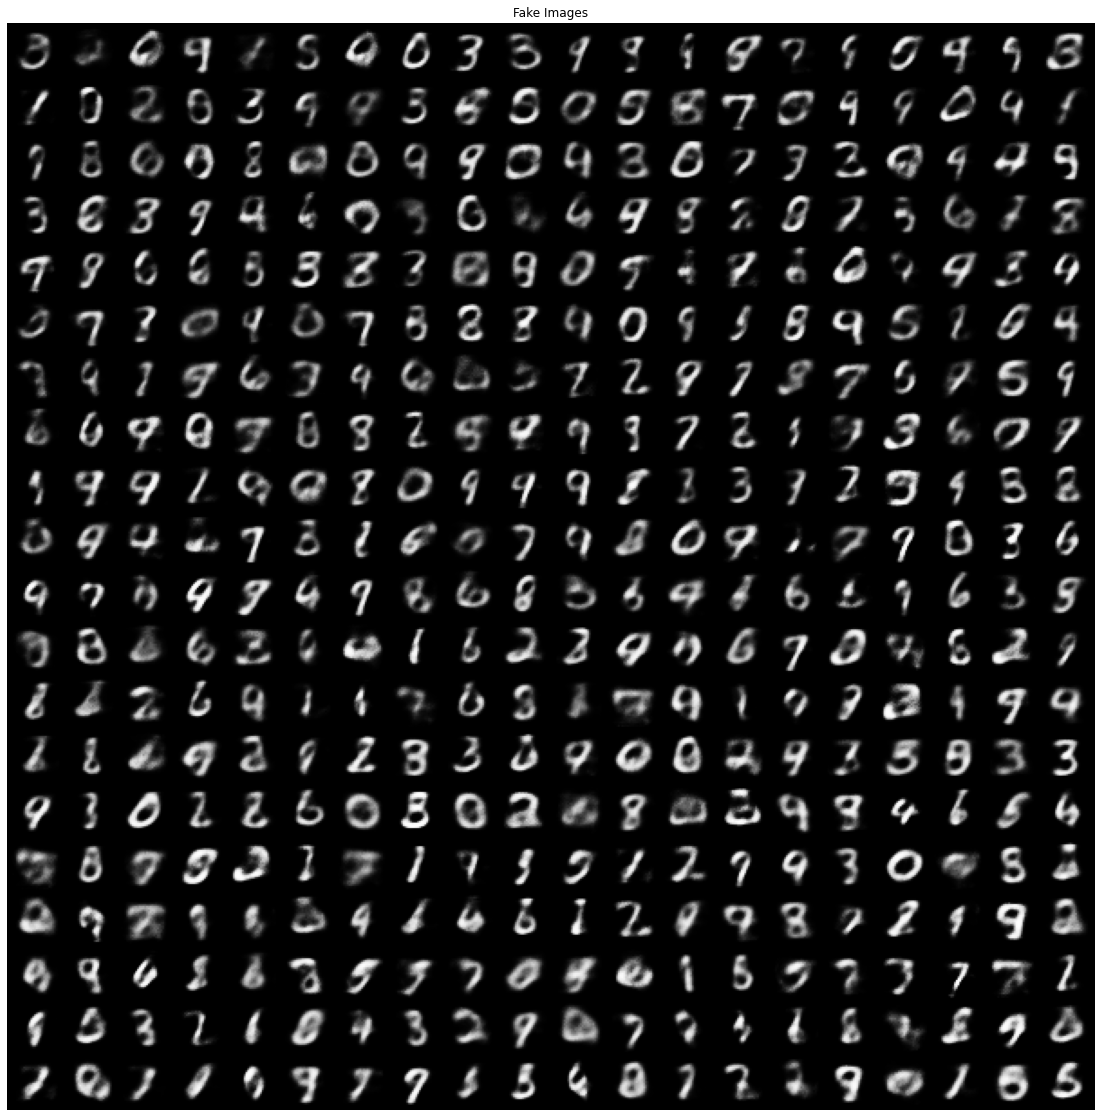

In [6]:
device = 'gpu' if torch.cuda.is_available() else 'cpu'
print(f'running on {device}')

# Model parameters
img_size = 28
dim_inter_enc = 128
dimlat = 10
dim_inter_dec = 128
vae = VAE(img_size**2, dim_inter_enc, dimlat, dim_inter_dec, device)

# Training parameters
nEpoch = 20
verbose = 1
save_freq_img = 5
C = 1
eta = 0.0001
BCE=torch.nn.BCELoss(reduction='sum')
optim = torch.optim.Adam(vae.parameters(), lr = eta)
now = datetime.now()
date_time = now.strftime("%d-%m-%Y-%HH%M-%SS")
logging_path = 'runs' + '/VAE_' + date_time
writer = SummaryWriter(logging_path)


for epoch in range(nEpoch):
    ### Training ###

    print(f'Epoch {epoch} / {nEpoch}')
    print('train')
    losses = 0
    losses1 = 0
    losses2 = 0
    
    for idx, (batchx, _) in enumerate(mnist_train_loader) :
    
        batchx = batchx.to(device).reshape(b_size, 28*28) # [100, 784] (batchx is [10, 1, 28, 28])

        optim.zero_grad() #re initialize gradients to 0
        
        batchx_hat, mu_hat, logsigma2_hat= vae.forward(batchx) #[100, 784]
        
        l1 = vae.kl(mu_hat, logsigma2_hat)
        l2 = BCE(batchx_hat, batchx)
        
        l = l1 + C * l2
        
        l.backward() #calcul des gradients
        optim.step()
        
        losses += l.item()
        losses1 += l1.item()
        losses2 += l2.item()

    writer.add_scalar(f'VAE/Train/Loss/Epoch{nEpoch}', losses/nBatchTrain, epoch)
    writer.add_scalar(f'VAE/Train/KL/Epoch{nEpoch}', losses1/nBatchTrain, epoch)
    writer.add_scalar(f'VAE/Train/BCE/Epoch{nEpoch}', losses2/nBatchTrain, epoch)

    ### Testing current network ###
    with torch.no_grad() :
        lTest = 0
        print('test time !')
        for idx, (batchx, _) in enumerate(mnist_test_loader):
            
            batchx = batchx.to(device).reshape(b_size, img_size**2)

            batchx_hat, mu_hat, logsigma2_hat = vae.forward(batchx)
            
            lTest += vae.kl(mu_hat, logsigma2_hat) + BCE(batchx_hat, batchx)

        writer.add_scalar(f'VAE/Test/Loss/', lTest/nBatchTest, epoch)
        
    ### Printing Infos and log images in tensorboard ###
    if epoch%verbose == 0 :
        print(f"Train : Epoch {epoch} \t Loss = {losses/nBatchTrain}") # should print the mean over le last 10 epoch instead for more stability
        print(f"Train : Epoch {epoch} \t KL = {losses1/nBatchTrain}") # should print the mean over le last 10 epoch instead for more stability
        print(f"Train : Epoch {epoch} \t BCE = {losses2/nBatchTrain}") # should print the mean over le last 10 epoch instead for more stability
        print(f"Test : Epoch {epoch} \t Loss = {lTest/nBatchTest}") # same comment    
    with torch.no_grad():
        if epoch==0 or epoch%save_freq_img==0: 
            noise = torch.randn(32, dimlat, device=device)
            fake = vae.decoder.forward(noise).reshape(32, 1, img_size, img_size) # [32, 1, 28, 28]
            grid = make_grid(fake)
            writer.add_image('images', grid, epoch)
    print('\n')
    

with torch.no_grad():
    noise = torch.randn(32, dimlat, device=device)
    fake = vae.decoder.forward(noise).reshape(32, 1, img_size, img_size) # [32, 1, 28, 28]
    grid = make_grid(fake)
    writer.add_image('images', grid, nEpoch)
    
    x = torch.arange(-1, 1, 0.1)
    y = torch.arange(-1, 1, 0.1)
    noise = torch.cartesian_prod(x, y)
    if dimlat == 1:
        noise = torch.arange(-1, 1, 0.1).unsqueeze(1)
        fake = vae.decoder.forward(noise).reshape(noise.shape[0], 1, img_size, img_size) # [32, 1, 28, 28]
        img = vutils.make_grid(fake, nrow = noise.shape[0], padding=2, normalize=True)
    elif dimlat == 2:
        fake = vae.decoder.forward(noise).reshape(noise.shape[0], 1, img_size, img_size) # [32, 1, 28, 28]
        img = vutils.make_grid(fake, nrow = y.shape[0], padding=2, normalize=True)
    elif dimlat>2 :
        noise = torch.cat((noise, torch.randn(noise.shape[0], dimlat - noise.shape[1], device=device)), 1)
        fake = vae.decoder.forward(noise).reshape(noise.shape[0], 1, img_size, img_size) # [32, 1, 28, 28]
        img = vutils.make_grid(fake, nrow = y.shape[0], padding=2, normalize=True)
    
    fig = plt.figure(figsize=[20, 20])
    plt.axis("off")
    plt.title("Fake Images")
    plt.imshow(img.permute(1, 2, 0))
    plt.savefig("fake.png")

In [ ]:
!tensorboard --logdir runs


NOTE: Using experimental fast data loading logic. To disable, pass
    "--load_fast=false" and report issues on GitHub. More details:
    https://github.com/tensorflow/tensorboard/issues/4784

I0301 18:05:16.563002 6198276096 plugin.py:305] Monitor runs begin
Serving TensorBoard on localhost; to expose to the network, use a proxy or pass --bind_all
TensorBoard 2.6.0 at http://localhost:6009/ (Press CTRL+C to quit)
